179
log.file	state/execs/179.exec/log
Simulator.reqParams	grammar=1&cite=1&learn=1&logging=0
Simulator.logFiles	./interactive/queries/freebuild.def.json.gz
103873 queries in plotInfo

{'total_rules': 2784, 'total_failed': 157, 'total_def_queries': 2388, 'total_body': 15511}
failpercent: 0.0101
num_body: 6.4954 ~ 13.0892 [ 1.0 - 96.0 ]


KeyError: 'stats.dist_children'

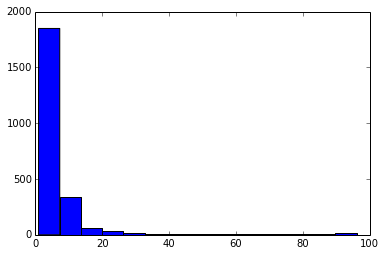

In [22]:
import csv
import numpy as np
import pandas as pd  
import matplotlib
import matplotlib.pyplot as plt
import json
import os
import subprocess
from collections import OrderedDict
%matplotlib inline  

with open('../state/lastExec', 'rb') as lastExec:
    lastExecInd = lastExec.readline().strip()
print lastExecInd
     
rows = []; 
execInd = lastExecInd;
execPath = '../state/execs/%s.exec/' % execInd
#print 'analyzing: ' + execPath
def printOptions():
    with open(os.path.join(execPath,'options.map')) as optionsfile:
        opts = filter(lambda l: 'file' in l or 'logFiles' in l  or 'reqParams' in l, optionsfile.readlines());
        for opt in opts: print opt.strip()
    # egrep 'file|Simulator'
printOptions()

with open('../state/execs/%s.exec/plotInfo.json' % execInd, 'rb') as jsonfile:
    json_lines = jsonfile.readlines()

rawrows = [json.loads(l) for l in json_lines]
rows = [r for r in rawrows if r.has_key('stats.type')]

print '%d queries in plotInfo' % len(json_lines)

def print_defstats():
    filtered_rows = [r for r in rows if r['stats.type'] == 'def' and r['stats.num_rules'] >= 1]
    total_failed = np.sum([r['stats.num_failed'] for r in filtered_rows])
    total_body = np.sum([r['stats.num_body'] for r in filtered_rows])

    stats =  {\
           'total_def_queries': len(filtered_rows), \
           'total_rules': np.sum([r['stats.num_rules'] for r in filtered_rows]), \
           'total_failed': total_failed, \
           'total_body': total_body
           }
    print ''
    print stats
    print 'failpercent: %.4f' % (float(total_failed)/float(total_body))
    
    keys = ['num_body', 'dist_children', 'dist_color', 'dist_number', 'dist_set', 'dist_action'];
    keys = keys + ['all_color', 'all_number', 'all_set', 'all_action'];
    keys = keys + ['rhssize', 'argsize', 'argcolor', 'argnum', 'argset', 'argaction'];
    for key in keys:
        data = [r['stats.' + key] for r in filtered_rows];
        print '%s: %.4f ~ %.4f [ %.1f - %.1f ]' % (key, np.mean(np.array(data)), np.std(np.array(data)), np.min(np.array(data)), np.max(np.array(data)))
        plt.figure()
        plt.hist(data, 15)
print_defstats()

In [23]:


def print_stats():
    filtered_rows = [r for r in rows if r['stats.type'] == 'accept']
    induced_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status']=='Induced']
    core_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status']=='Core']
    none_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status']=='Nothing']

    stats =  {\
           'accepted': len(filtered_rows), \
           'induced': len(induced_rows), \
           'inducedp':len(induced_rows)/float(len(filtered_rows)),\
           'core': len(core_rows), \
           'corep':len(core_rows)/float(len(filtered_rows)),\
           'none': len(none_rows), \
           'nonep':len(none_rows)/float(len(filtered_rows))\
           }
    print '\nCount of accepted query / percentage'
    print ' total:{accepted}\n induced:{induced}({inducedp:.4f})\n core:{core}({corep:.4f})\n none:{none}({nonep:.4f}),'.format(**stats)
    #print 'check %f' % (stats['inducedp']+stats['corep']+stats['nonep'])
    
    statscorrect = {
        'accepted0': np.mean([1 if r['stats.rank']==0 and r['stats.status']!='Nothing' else 0 for r in filtered_rows]),\
        'accepted1': np.mean([1 if r['stats.rank']>=0 and r['stats.status']!='Nothing'  else 0 for r in filtered_rows]),\
        'induced0': np.mean([1 if r['stats.rank']==0 and r['stats.status']=='Induced' else 0 for r in filtered_rows]),\
        'induced1': np.mean([1 if r['stats.rank']>=0 and r['stats.status']=='Induced' else 0 for r in filtered_rows]),\
        'core0': np.mean([1 if r['stats.rank']==0 and r['stats.status']=='Core' else 0 for r in filtered_rows]),\
        'core1': np.mean([1 if r['stats.rank']>=0 and r['stats.status']=='Core' else 0 for r in filtered_rows])\
    }
    print '\nranked 1 accepted / found accepted'
    print ' total:{accepted0:.4f}/{accepted1:.4f}\n induced:{induced0:.4f}/{induced1:.4f}\n core:{core0:.4f}/{core1:.4f}'.format(**statscorrect)

    token_types = set();
    rows_types = [r for r in rows if r['stats.type'] == 'q'];
    for r in rows_types:
        token_types |= set(r['q'].split(' '))
        
    print '\nThere are %d token types of %d query types' % (len(token_types), len(rows_types))
print_stats()

def percent_core():
    allq = [r for r in rows if r['stats.type'] == 'accept'];
    is_status = [100 if r['stats.status'] == 'Induced' else 0 for r in allq]
    print 'percent_induced %f' % np.mean(is_status)
    print 'percent_induced_last10k %f' % np.mean(is_status[len(is_status)-10000:])
percent_core()

# print filtered_rows[0]



def percent_error():
    allerror = [r for r in rawrows if r.has_key('stats.error')];
    alluerror = [r for r in rawrows if r.has_key('stats.uncaught_error')];
    print 'errors %d (%d uncaught)' % (len(allerror), len(alluerror))
percent_error()


Count of accepted query / percentage
 total:36589
 induced:26674(0.7290)
 core:9774(0.2671)
 none:141(0.0039),

ranked 1 accepted / found accepted
 total:0.9225/0.9907
 induced:0.6616/0.7244
 core:0.2609/0.2663

There are 5388 token types of 64075 query types
percent_induced 72.901692
percent_induced_last10k 85.940000
errors 549 (3 uncaught)


avg(stats.size): 8.730192
avg(percent of status Induced): 72.901692
avg(percent of status Core): 26.712947
avg(percent of status Nothing): 10.852737
avg(percent of status Induced): 67.343269
avg(percent of status Core): 21.803994


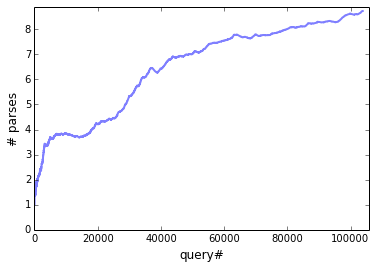

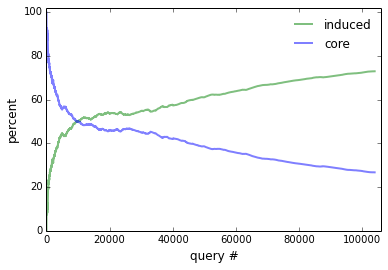

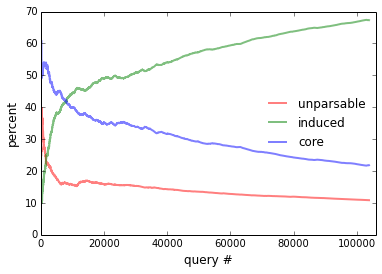

In [27]:

def plot_reset():
    global p
    p = {'color': 'r', 'linewidth': 2, 'alpha':0.5}
                       #, 'marker':'*', 'markersize':0.3}
plot_reset()
def savefig(filename = 'fig.pdf'):
    plt.savefig(os.path.join('.', str(execInd) + '-' + filename) ,  bbox_inches="tight")
    plt.savefig(os.path.join('.', str(execInd) + '-' + filename + '.png') ,  bbox_inches="tight")

def plot_cumavg(x, y, xlabel='query#', ylabel='recall', title=None):
    y_cum = np.cumsum(y).tolist()
    #print accepts_np[:,1]
    y_cumavg = [cum / float(count+1) for count,cum in enumerate(y_cum)]
    #N = 500;
    #y_cumavg = np.convolve(np.array(y), np.ones((N,))/N, mode='same').tolist()
    #print accept_rate 
    #plt.scatter(means_baseline[0:], means[0:], s=colors, alpha=0.8, c='r')
    plt.plot(x, y_cumavg, **p)
    
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    # plt.xlim(0, 0.65)
    plt.ylim(0, max(y_cumavg)*1.02)
    plt.xlim(0, len(rows)*1.02)
    xp = np.linspace(0, 0.65, 300)
    
    #plt.gca().set_aspect('equal', adjustable='box')
    plottitle = title if title is not None else '%s_vs_%s.pdf' % (xlabel, ylabel)
    # plt.savefig(os.path.join(execPath,plottitle) ,  bbox_inches="tight")
    
def print_avg(x, name = 'unnamed'):
    print 'avg(%s): %f' % (name, reduce(lambda a,b: a+b, x) / float(len(x)));
def average_stat(stat = 'stats.size', type = 'accept'):
    filtered_rows = [r for r in rows if r['stats.type'] == type]
    query_counts = [r['queryCount'] for r in filtered_rows]
    stats = [r[stat] for r in filtered_rows]
    plot_cumavg(query_counts, stats, xlabel='query#', ylabel=stat.replace('stats.','').replace('size','# parses'));
    print_avg(stats, stat)
plt.figure()
p['color'] = 'b'
average_stat(stat = 'stats.size')
#savefig('ambiguity.pdf')


def precent_status(filtered_rows, status = 'Core'):
    query_counts = [r['queryCount'] for r in filtered_rows]
    is_status = [100 if r['stats.status'] == status else 0 for r in filtered_rows]
    print_avg(is_status, 'percent of status ' + status)
    plot_cumavg(query_counts, is_status, xlabel='query #', ylabel='percent');


def plotCoreInducedNone(filtered_rows):
    p['color'] = 'g'; p['label'] = 'induced';
    precent_status(filtered_rows,status = 'Induced');
    p['color'] = 'b'; p['label'] = 'core';
    precent_status(filtered_rows, status = 'Core');
    plt.legend(frameon=False)
    
plt.figure()
plotCoreInducedNone([r for r in rows if r['stats.type'] == 'accept'])
# savefig('parse_status_accepted.pdf')

def plotCoreInducedNone(filtered_rows):
    p['color'] = 'r'; p['label'] = 'unparsable';
    precent_status(filtered_rows, status = 'Nothing');
    p['color'] = 'g'; p['label'] = 'induced';
    precent_status(filtered_rows,status = 'Induced');
    p['color'] = 'b'; p['label'] = 'core';
    precent_status(filtered_rows, status = 'Core');
    plt.legend(loc='center right', frameon=False)
    
plt.figure()
plotCoreInducedNone([r for r in rows if r['stats.type'] == 'q' and r.has_key('stats.status')])
plt.ylim(0, 70)
savefig('parse_status_q.pdf')

In [ ]:
def top_users(counts, line):
    id = 'sessionId'
    if line[id] in counts:
        counts[line[id]] = counts[line[id]] + 1
    else:
        counts[line[id]] = 1
    return counts

accept_all = [r for r in rows if r['stats.type']=='accept']
accept_nothing = [r for r in rows if r['stats.type']=='accept' and r['stats.status']=='Nothing']

for r in accept_nothing[:5]:
    print '{q}'.format(**r)
    
sorted(reduce(top_users, rows, {}).items(), key=lambda x: -x[1]);

In [ ]:
def precent_status_user(filtered_rows):
    query_counts = [r['queryCount'] for r in filtered_rows]
    is_status = [100 if r['stats.status'] == 'Induced' else 0 for r in filtered_rows]
    plot_cumavg(query_counts, is_status, xlabel='query #', ylabel='precent induced');

rows_to_count = [r for r in rows if r['stats.type'] == 'accept']
ranked_users = sorted(reduce(top_users, rows_to_count[5000:], {}).items(), key=lambda x: -x[1])

plt.figure()
topnum = 5;
plot_reset()
p['alpha'] = 1;
p['linewidth'] = 5;
p['label'] = 'all'; 
p['color'] = 'k';
precent_status_user([r for r in rows if r['stats.type'] == 'accept']);    

colors = ['c', 'r', 'm', 'y', 'b', 'g']
plot_reset()
p['alpha'] = 1;
p['linewidth'] = 5;
p['alpha'] = 0.5;
p['marker'] = 'o';
p['markersize'] = 1;

for g in enumerate(ranked_users[0:5]):
    # (0, (u'AMT_A1HKYY6XI2OHO1', 2830))
    p['label'] = '#%d' % (g[0]+1);
    #plotsetting['alpha'] = 1-float(g[0])/topnum;
    p['color'] = colors[g[0]];
    # print plotsetting['color']
    precent_status_user([r for r in rows if r['stats.type'] == 'accept' and r['sessionId'] == g[1][0]])
    print g

plt.ylim(-0.1, 100)
plt.legend(frameon=False, loc='lower right')
savefig('parse_status_topuser.pdf');

In [ ]:
def expressivity(status = 'Core'):
    filtered_rows = [r for r in rows if r['stats.type'] == 'accept' and r['stats.status'] == status]
    query_counts = [r['queryCount'] for r in filtered_rows]
    len_formula = [r['stats.len_formula'] for r in filtered_rows]
    len_utterance = [r['stats.len_utterance'] for r in filtered_rows]
    form_per_q = [float(ls[0])/ls[1] for ls in zip(len_formula, len_utterance)]
    plot_cumavg(query_counts, form_per_q, xlabel='query#', ylabel='"expressiveness"');

    #plot_cumavg(query_counts, len_utterance, xlabel='query#', ylabel='length');
    print_avg(form_per_q, 'formula length')
plt.figure()
plot_reset()
p['color'] = 'b'; p['label'] = 'core'; expressivity('Core')
p['color'] = 'g'; p['label'] = 'induced'; expressivity('Induced')
plt.legend(frameon=False, loc='upper left')
# savefig('expressiveness.pdf')


In [ ]:
def expressivity_by_users(filtered_rows):
    query_counts = [r['queryCount'] for r in filtered_rows]
    len_formula = [r['stats.len_formula'] for r in filtered_rows]
    len_utterance = [r['stats.len_utterance'] for r in filtered_rows]
    form_per_q = [float(ls[0])/ls[1] for ls in zip(len_formula, len_utterance)]
    plot_cumavg(query_counts, form_per_q, xlabel='query#', ylabel='len(z) / len(x)');

plot_reset()
plt.figure()
p['alpha'] = 1;
p['linewidth'] = 5;
p['label'] = 'all'; 
p['color'] = 'k';
expressivity_by_users([r for r in rows if r['stats.type'] == 'accept' ])
    
colors = ['c', 'r', 'm', 'y', 'b']
plot_reset()
p['alpha'] = 1;
p['linewidth'] = 5;
p['alpha'] = 0.5;
p['marker'] = 'o';
p['markersize'] = 1;
rows_to_count = [r for r in rows if r['stats.type'] == 'accept']
ranked_users = sorted(reduce(top_users, rows_to_count, {}).items(), key=lambda x: -x[1])
for g in enumerate(ranked_users[0:5]):
    print g
    p['label'] = '#%d' % (g[0]+1);
    p['color'] = colors[g[0]];
    expressivity_by_users([r for r in rows if r['stats.type'] == 'accept' \
                     and r['sessionId'] == g[1][0]])

plt.ylim([0,30])
plt.legend(frameon=False, loc='lower right')
savefig('expressiveness_by_user.pdf')

In [ ]:
def query_reformulation_by_user():
    q_all = [r for r in rows if r['stats.type']=='q']
    q_nothing = [r for r in rows if r['stats.type']=='q' and r.has_key('stats.status') and r['stats.status']=='Nothing']
    print 'q_nothing: %d / %d totallines: %d' % (len(q_nothing), len(q_all), len(json_lines))
    ranked_users = sorted(reduce(top_users, q_all, {}).items(), key=lambda x: -x[1])

    num_user = 10;
    num_query = 500;
    for g in (ranked_users[0:num_user]):
        print g
        print '********************'
        rows_userg = [r for r in rows if r['stats.type']=='q' and r['sessionId']==g[0] and r.has_key('stats.status') ]
        print_count = 0
        prev_nothing = False
        for r in rows_userg[-num_query:]:
            if prev_nothing or r['stats.status']=='Nothing':
                print_count = print_count + 1
                if print_count>100: break
                print r['stats.status'] + ':\t'  + r['q'].replace('(:q "','').replace('")','')
            prev_nothing = True if r['stats.status']=='Nothing' else False

query_reformulation_by_user()